## Usage

This notebook assumes that you have LMA data, which can be obatained at [$URL](http://pogo.tosm.ttu.edu/data/TRACER/).

Clone the https://github.com/AdamTheisen/cell-track-stats repo, which provides the CSAPR scan data tables used here.

Below, change the path to the case data files you want to load.

If the interactive widget functionality causes problems,  you can switch the import to `%matplotlib inline` and the animation loop will still run and save figures correctly. The notebook plot won't update until you redisplay the figure.

Don't have one of these files? Just set it to None.

[ESCAPE mission table](http://catalog.eol.ucar.edu/escape/missions)

In [1]:
# LMA data
lma_filename = '/data/Houston/LIGHTNING/6sensor_minimum/LYLOUT_220619_000000_86400_map500m.nc'
# lma_filenames = ['/data/Houston/LIGHTNING/6sensor_minimum/LYLOUT_220602_000000_86400_map500m.nc', '/data/Houston/LIGHTNING/6sensor_minimum/LYLOUT_220603_000000_86400_map500m.nc']

# From DOE / Adam Theisen repo
csapr_scan_csv_filename =  '/data/Houston/CSAPR-TRACER-cell-track-stats/data/houcsapr.20220619.csv'

# ESCAPE aircraft tracks, from a non-public dataset.
# Two research flights on this day? Add both below, or set to None if no flight.
convair_track_filenames = None # ['/data/Houston/AircraftTracks/Convair/C_RF13/20220617_F13.csv',]
lear_track_filenames = None 
#['/data/Houston/AircraftTracks/Learjet/L_RF10/Learjet_20220617_115141_specparams_m300.txt',
#'/data/Houston/AircraftTracks/Learjet/L_RF11/Learjet_20220617_155148_specparams_m300.txt']

In [2]:
# Radar scan tables for all cases, harvested manually
# from the EOL field catalog and the OU ARRC archive display.
px_1k_csv_filename = '../../data/PX1000.csv'
raxpol_csv_filename = '../../data/RaXPol.csv'
skyler_csv_filename = '../../data/SKYLER.csv'

In [4]:
# Files in this directory will be overwritten.
# If the directory does not exist, it will be created.
animation_output_directory = './figures/0619'

## Imports

In [5]:
import glob
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import pyproj as proj4

from pyxlma.lmalib.io import read as lma_read
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats, filter_flashes
from pyxlma.lmalib.grid import  create_regular_grid, assign_regular_bins, events_to_grid
# from pyxlma.plot.xlma_plot_feature import color_by_time, plot_points, setup_hist, plot_3d_grid, subset
# from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot
from pyxlma.plot.interactive import InteractiveLMAPlot
from pyxlma.plot.interactive import output as lma_plot_output

import sys, glob
from io import StringIO

from lmalibtracer.coords.sbu import get_sbu_proj as get_coord_proj

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
def np_strftime(d, fmt):
    "Have to convert to not nanoseconds, e.g. d.astype('M8[s]')"
    import datetime
    return d.astype(datetime.datetime).strftime(fmt)

In [8]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import num2date

from ipywidgets import Output
output = Output()

## Load data

In [9]:
# starttimes = []
# endtimes = []
# dss = []
# for lma_filename in lma_filenames:
#     ds = xr.open_dataset(lma_filename)
#     dss.append(ds.drop_dims([d for d in ds.dims.keys() if 'grid' in d]+['station_code']))
#     starttime, endtime = ds.grid_time_edge[0].data, ds.grid_time_edge[-1].data
#     starttimes.append(starttime)
#     endtimes.append(endtime)
# startime, endtime = min(starttimes), min(endtimes)

In [10]:
# xr.combine_nested(dss, concat_dim=dss[0].dims.keys())

In [11]:
if lma_filename is not None:
    ds = xr.open_dataset(lma_filename)
    starttime, endtime = ds.grid_time_edge[0].data, ds.grid_time_edge[-1].data
else:
    starttime, endtime = None, None

In [12]:
starttime, endtime

(array('2022-06-19T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2022-06-20T00:00:00.000000000', dtype='datetime64[ns]'))

### Research radar scans

In [13]:
csapr_lon, csapr_lat = -95.283893, 29.531782

def load_csapr_scan_table(csapr_scan_csv_filename):
    csapr_arm = pd.read_csv(csapr_scan_csv_filename, 
        parse_dates=['time']).drop('Unnamed: 0', axis='columns').rename(
        {'azimith_max':'azimuth_max'}, axis='columns')
    csapr_arm['rhi/ppi'] = csapr_arm['scan_mode']
    csapr_arm['date_time_start'] = csapr_arm['time']

    # Use the start of the next time window as the end of the current time window.
    # Needs a minus sign due to periods=-1.
    csapr_arm['date_time_end'] = csapr_arm['date_time_start'] - csapr_arm['time'].diff(periods=-1)

    csapr_arm['longitude'] = csapr_lon
    csapr_arm['latitude'] = csapr_lat
    
    csapr_arm_final = None
    for mode, table in  csapr_arm.groupby('scan_mode'):
        d_az = (table.azimuth_max-table.azimuth_min).abs().max()
        d_el = (table.elevation_max-table.elevation_min).abs().max()
        print(f"Max azimuth difference of {d_az} for {mode}")
        print(f"Max elevation difference of {d_el} for {mode}")
        constant_angle = 'n/a'
        sweep_angle = 'n/a'
        # print('-'+mode+'-')
        if mode == 'rhi':
            print('rhi found')
            # Also handles hsrhi
            if d_az < 1.0:
                constant_angle = table.azimuth_max.astype('str')
            else:
                constant_angle = csapr_arm.azimuth_min.map('{:3.2f}'.format) + ',' + csapr_arm.azimuth_max.map('{:3.2f}'.format)
            sweep_angle = csapr_arm.elevation_min.map('{:3.2f}'.format) + '-' + csapr_arm.elevation_max.map('{:3.2f}'.format)   
        if mode == 'ppi':
            print('ppi found')
            sweep_angle = csapr_arm.azimuth_min.map('{:3.2f}'.format) + '-' + csapr_arm.azimuth_max.map('{:3.2f}'.format)
            constant_angle = csapr_arm.elevation_min.map('{:3.2f}'.format) + '-' + csapr_arm.elevation_max.map('{:3.2f}'.format)        
        # print(constant_angle)
        # print(sweep_angle)

        table['constant angle'] = constant_angle
        table['sweep angle range'] = sweep_angle
        if csapr_arm_final is None:
            csapr_arm_final = table
        else:
            print(len(csapr_arm_final), len(table))
            csapr_arm_final = csapr_arm_final.append(table, ignore_index=True)
            print(len(csapr_arm_final))
    return csapr_arm_final

In [14]:
if csapr_scan_csv_filename is not None:
    csapr = load_csapr_scan_table(csapr_scan_csv_filename)
else:
    csapr = None
    
if (starttime is None) or (endtime is None):
    starttime = csapr_arm_final.time.min()
    endtime = csapr_arm_final.time.max()

Max azimuth difference of 290.46752699999996 for hsrhi
Max elevation difference of 182.23022703 for hsrhi
Max azimuth difference of 359.07714599999997 for ppi
Max elevation difference of 27.004395000000002 for ppi
ppi found
222 256
478
Max azimuth difference of 0.06591800000000347 for rhi
Max elevation difference of 38.77075164 for rhi
rhi found
478 560
1038
Max azimuth difference of 359.0414431 for vpt
Max elevation difference of 0.46142399999999384 for vpt
1038 108
1146


In [15]:
# See a table of PPIs
# csapr_arm_final[csapr_arm_final.scan_mode=='ppi']

In [16]:
if px_1k_csv_filename is not None:
    px1k = pd.read_csv(px_1k_csv_filename, parse_dates=['date_time_start', 'date_time_end'])
    if 'sweep angle range' not in px1k.columns:
        px1k['sweep angle range'] =  pd.Series(['n/a']*len(px1k))
else:
    px1k = None

In [17]:
# px1k.head(5)

In [18]:
if raxpol_csv_filename is not None:
    raxpol = pd.read_csv(raxpol_csv_filename, parse_dates=['date_time_start', 'date_time_end'])
    if 'sweep angle range' not in raxpol.columns:
        raxpol['sweep angle range'] =  pd.Series(['n/a']*len(raxpol))
else:
    raxpol = None

In [19]:
#raxpol.head(5)

In [20]:
if skyler_csv_filename is not None:
    skyler = pd.read_csv(skyler_csv_filename, parse_dates=['date_time_start', 'date_time_end'])
    if 'sweep angle range' not in skyler.columns:
        skyler['sweep angle range'] =  pd.Series(['n/a']*len(skyler))
else:
    skyler = None

In [21]:
# px1k = pd.read_csv('/data/Houston/PX1000_draft.csv').rename(columns={'time':'time_range'})
# px1k[['time_start_raw', 'time_end_raw']]=px1k.time_range.str.split('-', expand=True)
# px1k['date_time_start'] = pd.to_datetime(px1k['date'].astype(str) + px1k['time_start_raw'], format='%Y%m%d%H%M%S')
# px1k['date_time_end'] = pd.to_datetime(px1k['date'].astype(str) + px1k['time_end_raw'], format='%Y%m%d%H%M%S')

In [22]:
#px1k = px1k[(px1k['date_time_start'] > pd.to_datetime('2022-06-04T12:00:00')) & (px1k['date_time_end'] < pd.to_datetime('2022-06-05T12:00:00'))]

### Aircraft tracks

In [23]:
# These are KMLs from the ESCAPE EOL field catalog. Low-res, but public.
# from pykml import parser
# # from datetime import datetime, timedelta
# convair_filename = 'gis.NRC_Convair_580.20220604230246.flight_track.kml'
# lear_filename = 'gis.SPEC_LEAR.20220604220953.flight_track.kml'


In [24]:
# import pandas as pd

# def distance(a, b):
#     "a first, b last. A very non-exact way to get distances in meters."
#     dlon, dlat, dalt = (b.Lon - a.Lon)*111e3, (b.Lat - a.Lat)*111e3, (b.AltM - a.AltM)
#     return np.sqrt(dlon*dlon + dlat*dlat + dalt*dalt)/1000.0

# def assign_times_to_track(timed_df, track_df):
#     # Loop through the timed, but infrequent track data, and try to
#     # find the best match for each position in the whole track
#     last_match = None
#     for itimed, row in timed_df.sort_values('time').iterrows():
#         # Distance between every track position and this row
#         d = distance(track_df, row)

#         # Array position of the track dataset sorted by distance
#         idx_min = d.argsort()
#         if last_match is None:
#             # use the best match for the first point
#             this_match = idx_min[0]
#         else:
#             for sort_match_posn in idx_min:
#                 if sort_match_posn >= last_match:
#                     # find the closest distance that is after the last-matched position
#                     this_match = sort_match_posn
#                     break
#         # this_match = idx_min[this_match_sort_posn]
#         track_df.time_guess.iat[this_match] = row.time
#         # display(row)
#         # display(track_df.iloc[this_match])
#         # display(d[this_match])
#         # print('--')

#         # next matching time needs to be greater than or equal to this one
#         last_match = this_match
#     # display(track_df.tail(20))
#     min_time = track_df.time_guess.min()
#     dt = (track_df.time_guess - min_time).dt.total_seconds()
#     # print(dt)
#     track_df['time'] = min_time + dt.interpolate(limit_direction='both', method='linear').astype('m8[s]')

# def parse_kml(filename):
#     """
#         aircraft is one of "CONVAIR" or "LEAR"
#     """
    
#     # Look for the aircraft string in the KML's name attribute for each placemark
#     if "Convair" in filename:
#         aircraft = "CONVAIR"
#         filename_template = 'gis.NRC_Convair_580.%Y%m%d%H%M%S.flight_track.kml'
#     elif "LEAR" in filename:
#         aircraft = "LEAR"
#         filename_template = 'gis.SPEC_LEAR.%Y%m%d%H%M%S.flight_track.kml'
#     else:
#         raise ValueError("Unrecognized aircraft type")
        
#     end_time = datetime.datetime.strptime(filename, filename_template)
#     end_day = datetime.datetime(end_time.year, end_time.month, end_time.day)
#     if end_time.hour > 12:
#         print(aircraft, " flight ended before UTC day changed")
#         start_day = end_day
#     else:
#         start_day = end_day - timedelta(months=1)
#         print(aircraft, " flight ended after UTC day changed, setting flight start day to", start_day)
    
#     with open(filename, 'rb') as kml:
#         kml_convair = parser.parse(kml)
#     convair_root = kml_convair.getroot()


#     rows = []
#     # there are two track segements, "last hour" and "older"
#     track_segments = [0, 1]
#     for node in convair_root.iterdescendants():
#         if hasattr(node, 'name'):
#             if "Track" in str(node.name):
#                 coord_list = StringIO(str(node.LineString.coordinates))
#                 this_segment = pd.read_csv(coord_list, names=("Lon", "Lat", "Alt"))
#                 # ensure that things remain in order
#                 if 'old' in str(node.name):
#                     track_segments[0] = this_segment
#                 if 'last hour' in str(node.name):
#                     track_segments[1] = this_segment
#             if aircraft in str(node.name):
#                 time_str = str(node.name).replace(aircraft,"")
#                 if len(time_str) > 0:
#                     if int(time_str.split(':')[0]) < 12:
#                         the_day = end_day
#                     else:
#                         the_day = start_day
#                     t = pd.Timestamp(the_day.strftime('%Y-%m-%d ' + time_str))
#                     row = {'time':t}
#                     for data_entry in str(node.description).split("<br>"):
#                         parts = data_entry.split(":")
#                         if len(parts) > 1:
#                             var_name = parts[0].strip()
#                             value_unit = parts[1].split()
#                             row[var_name] = float(value_unit[0])
#                             unit = value_unit[1]
#                     rows.append(row)
#     timed_data = pd.DataFrame(rows)
#     track_data = pd.concat(track_segments).reset_index(drop=True)
#     timed_data['AltM'] = timed_data['Alt']/3.28084
#     track_data['AltM'] = track_data['Alt']/3.28084
#     track_data['time_guess'] = [pd.NaT]*track_data.shape[0]
    
#     assign_times_to_track(timed_data, track_data)
    
#     return timed_data, track_data

# # convair_df, convair_track_df = parse_kml(convair_filename)
# # lear_df, lear_track_df = parse_kml(lear_filename)

**Non-KML (1s) track data**

In [25]:
def load_lear_track(lear_track_filename):
    lear_track_df = pd.read_csv(lear_track_filename, sep='\s+', 
                       parse_dates={'time_raw':['yyyy', 'month', 'day', 'hh', 'mm','ss']})
    # Make the columns match the convair dataframe format.
    lear_track_df['time'] = pd.to_datetime(lear_track_df.time_raw, format='%Y %m %d %H %M %S')
    # ['time_raw', 'Latitude(deg)', 'Longitude(deg)', 'Head(deg)',
    #        'NevLWC(gm/m^3)', 'NevTWC(gm/m^3)', 'RICE(Hz)', 'RMTStatic(C)',
    #        'DewPoint(C)', 'TAS(m/s)', 'StaticP(mb)', 'Alt(ft)', 'VertWind(m/s)',
    #        'WndSpd(m/s)', 'WindDir(deg)', 'WindSolution', 'Roll(deg)',
    #        'Pitch(deg)', 'Yaw(deg)', 'time']
    lear_track_df['AltM']=lear_track_df['Alt(ft)']/3.28084
    lear_track_df['Lon']=lear_track_df['Longitude(deg)']
    lear_track_df['Lat']=lear_track_df['Latitude(deg)']
    return lear_track_df

def load_convair_track(convair_track_filename):
    convair_track_df = pd.read_csv(convair_track_filename,
        parse_dates=['Time']).rename(
        columns={'Time':'time','lon':'Lon','lat':'Lat','alt':'AltM'}
    )
    return convair_track_df

if lear_track_filenames is not None:
    lear_track_dfs = [load_lear_track(lear_track_filename) for lear_track_filename in lear_track_filenames]
    lear_track_df = pd.concat(lear_track_dfs)
else:
    lear_track_df = None

if convair_track_filenames is not None:
    convair_track_dfs = [load_convair_track(convair_track_filename) for convair_track_filename in convair_track_filenames]
    convair_track_df = pd.concat(convair_track_dfs)
else:
    convair_track_df = None
# 'Time', 'lat', 'lon', 'alt', 'roll', 'pitch', 'hdg', 'Psc', 'Ts', 'TAS',
       # 'hwspd', 'hwdir', 'vwind', 'mso', 'twc_nevz', 'lwc_nevz', 'lwc_cdp']


## Plot the VHF event data

xlma-python has built-in plotting capabilities to make a standard plot style that has a plan view, two vertical projections, and a time height view of the events.

We don't actually need the flash-sorted data, but it doesn't hurt to have it in the dataset.

In [26]:

# # Plot color map and marker size
# # plot_cmap = 'plasma'
# # plot_s = 5

# # tlim_sub = [pd.to_datetime(starttime), pd.to_datetime(pd.to_datetime(starttime) + np.asarray(30, 'timedelta64[m]'))]
# # tlim_sub = pd.to_datetime(starttime), pd.to_datetime(endtime)

# # Southern (Angleton/Jackson Lakes) cell
# # tlim_sub = pd.to_datetime('2022-06-04T20:55'), pd.to_datetime('2022-06-04T21:05')
# # clat, clon = 29.08, -95.4
# # dlat, dlon = .1, .1

# # Central Houston
# # Cell track
# # tlim_sub = pd.to_datetime('2022-06-04T20:45'), pd.to_datetime('2022-06-04T23:55')
# # Lightning
# tlim0 = pd.to_datetime('2022-06-04T22:15'), pd.to_datetime('2022-06-04T22:35')
# clat, clon = 29.9, -96.55
# dlat, dlon = .1, .1

# # tstring = 'LMA {}-{}'.format(tlim_sub[0].strftime('%H%M'),
# #                              tlim_sub[1].strftime('%H%M UTC %d %B %Y '))

# #float(ds.network_center_latitude), float(ds.network_center_longitude)
# xlim0 = [clon-dlon, clon+dlon]
# ylim0 = [clat-dlat, clat+dlat]
# zlim0 = [0, 15]
# xchi0 = 1.0
# stationmin0 = 6.0

# # END OF CONFIG

In [27]:
def overlapping_date_range(d_start, d_end, t_start, t_end):
    """
    d is data, t valid time range.
    ------------------------
    (ts > rs) & (ts < de) & (te > ds) & (te > de)
    d |      |
    t    |       |
    ------------------------
    (ts > ds) & (ts < de) & (te > ds) & (te > de)
    d    |      |
    t |       |
    ------------------------
    (ts > de)
    d    |      |
    t              |       |
    ------------------------
    (te < ds)
    d              |       |
    t    |      |
    ------------------------
    
    Not either of the last two should be sufficent.
    """
    in_range = ~((t_start > d_end) | (t_end < d_start))
    return in_range

In [28]:
def swap_angle_basis(angle):
    """ Switch from geographic to math angle, or vice versa, using this one weird trick."""
    return (450.0 - angle) % 360.0

def radar_ray_coords(radar_ctr, ray_angle, ray_distance_km=30):
    """ Returns an estimated ([lon0,lon_end], [lat0, lat_end]) in degrees
        for the given radar position, angle of the ray in degrees,  and distance 
    """
    ray_length = ray_distance_km / 111.0 # km/(km/deg)
    ray = np.deg2rad(ray_angle)
    return ([radar_ctr[0], radar_ctr[0] + ray_length*np.sin(ray)], 
            [radar_ctr[1], radar_ctr[1] + ray_length*np.cos(ray)])

In [29]:
class AnnotatedLMAPlot(InteractiveLMAPlot):
    # @output.capture()
    def make_plot(self):
        super(AnnotatedLMAPlot, self).make_plot()
        tlim = self.bounds['t']
        tlim_sub = pd.to_datetime(tlim[0]), pd.to_datetime(tlim[1])
        title = tlim_sub[0].strftime('%Y%m%d %H%M%S') + ' to ' + tlim_sub[1].strftime('%Y%m%d %H%M%S') + ' UTC'
        self.lma_plot.ax_th.set_title(title)
        
        # For longer durations, successive overplots of PPIs will 
        # completely hide the LMA data.
        plot_duration_sec = (tlim[1]-tlim[0]).total_seconds()
        if plot_duration_sec > 10*60:
            radar_alpha = 0.0 # transparent
        else:
            radar_alpha = 0.1 # slight shading
        
                
        for radar_name, radar_df, radar_color in zip(('PX1000', 'CSAPR', 'RaXPol', 'SKYLER'),
                (px1k, csapr, raxpol, skyler), ((.5,.5,.5), (.4,.4,.4), (.5,.5,.5), (.5,.5,.5))):

            # Skip any radar we don't have.
            if radar_df is None: continue
                        
            in_range = overlapping_date_range(radar_df['date_time_start'], radar_df['date_time_end'],
                                              self.bounds['t'][0], self.bounds['t'][1])
            radar_in_time = radar_df[in_range]
            # print(radar_in_time)
            radar_ctr = radar_in_time['longitude'].mean(), radar_in_time['latitude'].mean()
            ra, = self.lma_plot.ax_plan.plot(radar_ctr[0], radar_ctr[1], color=radar_color, marker='o', ms=4)
            radar_artists = [ra]
            for scan_type, scan_angle, sweep_angle_range in zip(radar_in_time['rhi/ppi'], radar_in_time['constant angle'],
                                             radar_in_time['sweep angle range']):
                # print(radar_name, scan_type, scan_angle, sweep_angle_range)
                if scan_type.lower() == 'rhi':
                    if scan_angle != 'n/a':
                        scan_angles = list(map(float, scan_angle.split(',')))
                        for ray in scan_angles:
                            # FIXME: do a proper map projection (or geod transform)
                            ray_lons, ray_lats = radar_ray_coords(radar_ctr, ray)
                            ra, = self.lma_plot.ax_plan.plot(ray_lons, ray_lats,
                                                       color=radar_color, linewidth=.5)
                            radar_artists.append(ra)
                if scan_type.lower() == 'ppi':
                    if sweep_angle_range != 'n/a':
                        geog_angle_start_end = tuple(map(float, sweep_angle_range.split('-')))
                        # Switch order, because the winding is CCW instead of CW
                        angle_end, angle_start = map(swap_angle_basis, geog_angle_start_end)
                        # if radar_name == 'CSAPR':
                            # print(geog_angle_start_end, (angle_start, angle_end))
                        ppi_range_km = 60.0
                        km_per_deg = 111.0
                        ra = matplotlib.patches.Wedge(radar_ctr, ppi_range_km/km_per_deg, angle_start, angle_end,
                                                         facecolor=radar_color+(radar_alpha,), edgecolor=radar_color)
                        self.lma_plot.ax_plan.add_artist(ra)
                    else:
                        ra, = self.lma_plot.ax_plan.plot(radar_ctr[0], radar_ctr[1],
                                                   markerfacecolor="None", marker='o', ms=16,
                                                   markeredgecolor=radar_color, markeredgewidth=.5)
                    radar_artists.append(ra)
            self.data_artists.extend(radar_artists)
                    
                    
        for track_df, track_highlight_color, whole_track_color in zip(
                (convair_track_df, lear_track_df), ('red', 'blue'), ((.9,.8,.8), (.8,.8,.9))):
            # Skip any aircraft we don't have.
            if track_df is None: continue

            # time_pad = pd.to_timedelta('3 min')
            time_pad = pd.to_timedelta('3 sec')
            track_in_time = ((track_df.time >= (self.bounds['t'][0]-time_pad)) & 
                             (track_df.time <= (self.bounds['t'][1]+time_pad)) &
                             (track_df.Lon >= self.bounds['x'][0]) & (track_df.Lon <= self.bounds['x'][1]) &
                             (track_df.Lat >= self.bounds['y'][0]) & (track_df.Lat <= self.bounds['y'][1])
                            )
        
            current_track = track_df[track_in_time]
            c0, = self.lma_plot.ax_plan.plot(track_df.Lon, track_df.Lat, color=whole_track_color, zorder=-10)
            c1, = self.lma_plot.ax_plan.plot(current_track.Lon, current_track.Lat, color=track_highlight_color)
            c2, = self.lma_plot.ax_th.plot(track_df.time, track_df.AltM/1000.0, color=whole_track_color, zorder=-10)
            c3, = self.lma_plot.ax_th.plot(current_track.time, current_track.AltM/1000.0, color=track_highlight_color)
            c4, = self.lma_plot.ax_lon.plot(track_df.Lon, track_df.AltM/1000.0, color=whole_track_color, zorder=-10)
            c5, = self.lma_plot.ax_lon.plot(current_track.Lon, current_track.AltM/1000.0, color=track_highlight_color)
            c6, = self.lma_plot.ax_lat.plot(track_df.AltM/1000.0, track_df.Lat, color=whole_track_color, zorder=-10)
            c7, = self.lma_plot.ax_lat.plot(current_track.AltM/1000.0, current_track.Lat, color=track_highlight_color)
            track_artists = [c0,c1,c2,c3,c4,c5,c6,c7]
            self.data_artists.extend(track_artists)

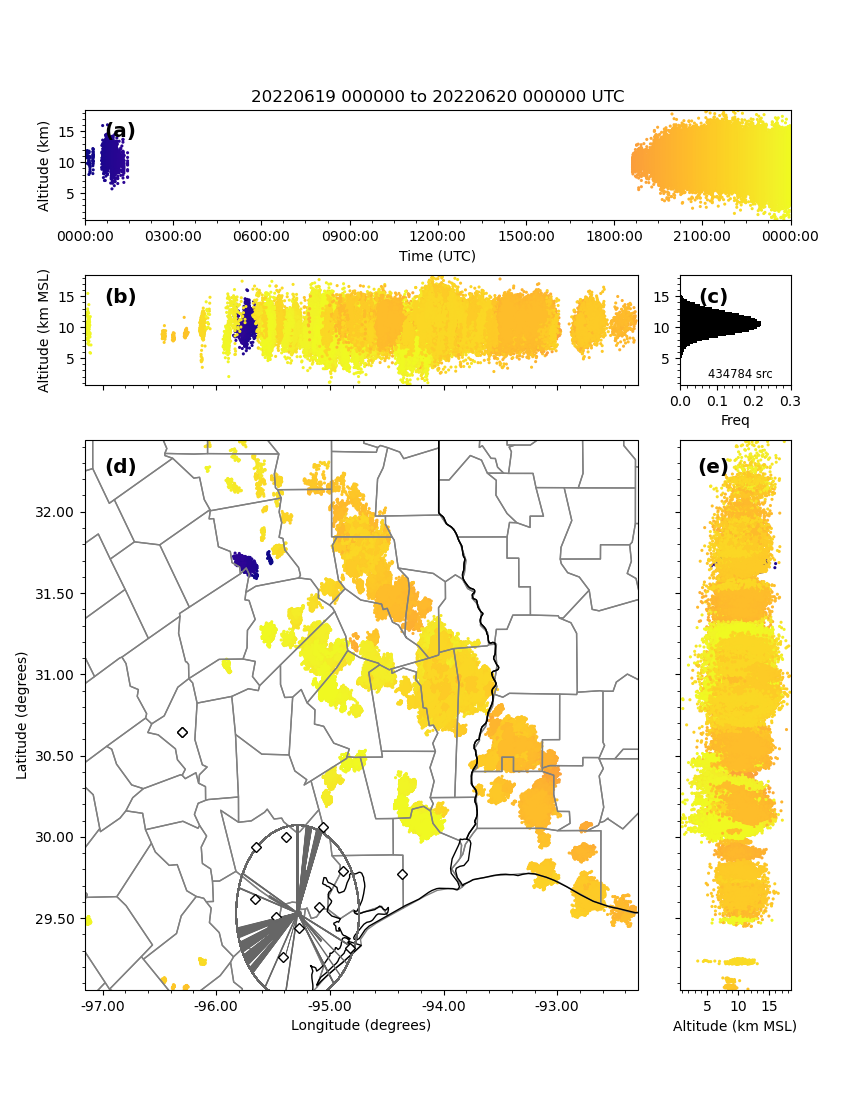

In [30]:
tlim = pd.to_datetime(starttime).to_pydatetime(), pd.to_datetime(endtime).to_pydatetime()
interactive_lma = AnnotatedLMAPlot(ds, tlim=tlim)

# Simpler version with no overlays
# interactive_lma = InteractiveLMAPlot(ds)

### Zoom to region of interest

In [31]:
lon_span = 2.0
lat_span = 2.0

xlim0 = csapr_lon - lon_span, csapr_lon + lon_span
ylim0 = csapr_lat - lat_span, csapr_lat + lat_span
zlim0 = (0, 18.0)
tlim0 = (pd.to_datetime(ds.flash_time_start.min().data),
         pd.to_datetime(ds.flash_time_end.max().data)
        )
# tf = pd.to_datetime('2022-06-04T23:00')
# tlim0 = pd.to_datetime('2022-06-02T15:30'), pd.to_datetime('2022-06-03T00:00')
# tlim0 = (t0, t0+tspan)
interactive_lma.lma_plot.ax_th.set_xlim(tlim0, emit=False)
interactive_lma.lma_plot.ax_th.set_ylim(zlim0, emit=False)
interactive_lma.lma_plot.ax_plan.set_xlim(xlim0, emit=False)
interactive_lma.lma_plot.ax_plan.set_ylim(ylim0)



(27.531782, 31.531782)

In [32]:
interactive_lma.bounds

{'x': (array(-97.15431, dtype=float32), array(-92.29403, dtype=float32)),
 'y': (array(29.058428, dtype=float32), array(32.44125, dtype=float32)),
 'z': (0.6573599853515625, 18.4280703125),
 't': (datetime.datetime(2022, 6, 19, 0, 0),
  datetime.datetime(2022, 6, 20, 0, 0))}

In [33]:
print("Ensuring path exists: ", animation_output_directory)
from pathlib import Path
import os
Path(animation_output_directory).mkdir(parents=True, exist_ok=True)

Ensuring path exists:  ./figures/0619


In [34]:
# Save an overview figure
interactive_lma.lma_plot.fig.savefig(os.path.join(animation_output_directory, 
                                                  "LMA_overview_"+tlim0[0].strftime('%Y%m%d')+'.png'))

## Make an animation

Because the interactive plot above can be changed programmatically, we can also change the time
in a loop and save a figure each time.

The second cell makes an .mp4 from the saved images; change the path to the ffmpeg command and the path to disk to match yours. The `pix_fmt`, etc. used is broadly compatible with powerpoint slides and the web across platforms. You'll need to change the `size` and `scale` to match that of the actual images being saved, too.

In [36]:
lon_span = 1.0
lat_span = 1.0

xlim0 = csapr_lon - lon_span, csapr_lon + lon_span
ylim0 = csapr_lat - lat_span, csapr_lat + lat_span
zlim0 = (0, 18.0)
# tlim0 = (pd.to_datetime(ds.flash_time_start.min().data),
#          pd.to_datetime(ds.flash_time_end.max().data)
#         )
tlim0 = pd.to_datetime('2022-06-19T20:30'), pd.to_datetime('2022-06-20T00:00')

interactive_lma.lma_plot.ax_th.set_xlim(tlim0, emit=False)
interactive_lma.lma_plot.ax_th.set_ylim(zlim0, emit=False)
interactive_lma.lma_plot.ax_plan.set_xlim(xlim0, emit=False)
interactive_lma.lma_plot.ax_plan.set_ylim(ylim0)

(28.531782, 30.531782)

In [37]:
interactive_lma.lma_plot.fig.savefig(os.path.join(animation_output_directory, 
                                                  "LMA_overviewzoom_"+tlim0[0].strftime('%Y%m%d')+'.png'))

In [38]:
if animation_output_directory is not None:
    import os

    dt = pd.to_timedelta('60 seconds')
    tspan = pd.to_timedelta('5 minutes')
    t0, tf = tlim0[0], tlim0[1]

    n_frames=int((tf-t0)/dt)
    time_limits = [(t0+iframe*dt, t0+tspan+iframe*dt) for iframe in range(n_frames)]
    for iframe, tlimi in enumerate(time_limits):
        ti0 = tlimi[0].strftime('%Y%m%d_%H%M%S')
        filename = os.path.join(f"{animation_output_directory}", f"LMA_aircraft_radar_{ti0}.png")
        interactive_lma.lma_plot.ax_th.set_xlim(tlimi)
        interactive_lma.lma_plot.fig.canvas.draw()
        interactive_lma.lma_plot.fig.savefig(filename)
        if (iframe % 25) == 0:
            print(iframe)
            print(filename)


0
./figures/0619/LMA_aircraft_radar_20220619_203000.png
25
./figures/0619/LMA_aircraft_radar_20220619_205500.png
50
./figures/0619/LMA_aircraft_radar_20220619_212000.png
75
./figures/0619/LMA_aircraft_radar_20220619_214500.png
100
./figures/0619/LMA_aircraft_radar_20220619_221000.png
125
./figures/0619/LMA_aircraft_radar_20220619_223500.png
150
./figures/0619/LMA_aircraft_radar_20220619_230000.png
175
./figures/0619/LMA_aircraft_radar_20220619_232500.png
200
./figures/0619/LMA_aircraft_radar_20220619_235000.png


In [52]:
%%bash
# Get a list of filenames, append 'file ' to the front of each to match ffmpeg's expected syntax
# Add a duration to help the video encoder not freak out about infinitely short concatenated "movies"
# ls ./figures/0619/*radar*.png ./figures/0620/*radar*.png | sort \
    # | sed -e 's/^/file /' | sed -e 's/$/\nduration 0.0625/g'> case_images.txt

/Applications/ffmpeg  -f image2 -f concat -safe 0 -i case_images.txt  \
   -r 16 -s 850x1100 -vcodec libx264 -crf 12 -vf scale=850:-1 -pix_fmt yuv420p \
   ./figures/20220619_lma_aircraft_radar_loop.mp4 </dev/null

#/Applications/ffmpeg -r 16 -s 850x1100 -f image2 -pattern_type glob -i './figures/0602/*radar*.png  \
#    -vcodec libx264 -crf 12 -vf scale=850:-1 -pix_fmt yuv420p ./figures/20220602_lma_aircraft_radar_loop.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [17]:
display(interactive_lma.widget_output)

Output()

## Looking at the gridded data

Plot flash extent density, etc.

### Add widget interactivity

[Interact!](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) It's possible to build much nicer interfaces, but this is enough for a quick look.

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual

from matplotlib.colors import Normalize, LogNorm

fed_norm = LogNorm(vmin=0.9,vmax=128) 
afa_norm = LogNorm(vmin=4,vmax=5000)

n_times = ds.dims['grid_time']
def plot(time_idx=0, fig=None, var='flash_extent_density', save=None, norm=Normalize()):
    "Save is a filename prefix. Doesn't save if None."
    fig.clear()
    ax = fig.add_subplot(1,1,1)
    trange = ds.grid_time_edge[time_idx:time_idx+2].data.astype('M8[s]')
    title = np_strftime(trange[0],'%Y-%m-%d %H:%M:%S') + ' to ' + np_strftime(trange[1],'%Y-%m-%d %H:%M:%S') + ' UTC'
    ds[var][time_idx, :, :].plot.imshow(ax=ax, norm=norm)
    ax.set_title(title)
    ax.axis((-200e3, 200e3, -200e3, 200e3))
    if save is not None:
        fname = save + np_strftime(trange[0],'%Y%m%d%-H%M%S') + '_' + np_strftime(trange[1],'%Y%m%d%-H%M%S') + '.png'
        # print(fname)
        fig.savefig(fname)

interactive(children=(IntSlider(value=0, description='time_idx', max=287), Output()), _dom_classes=('widget-in…

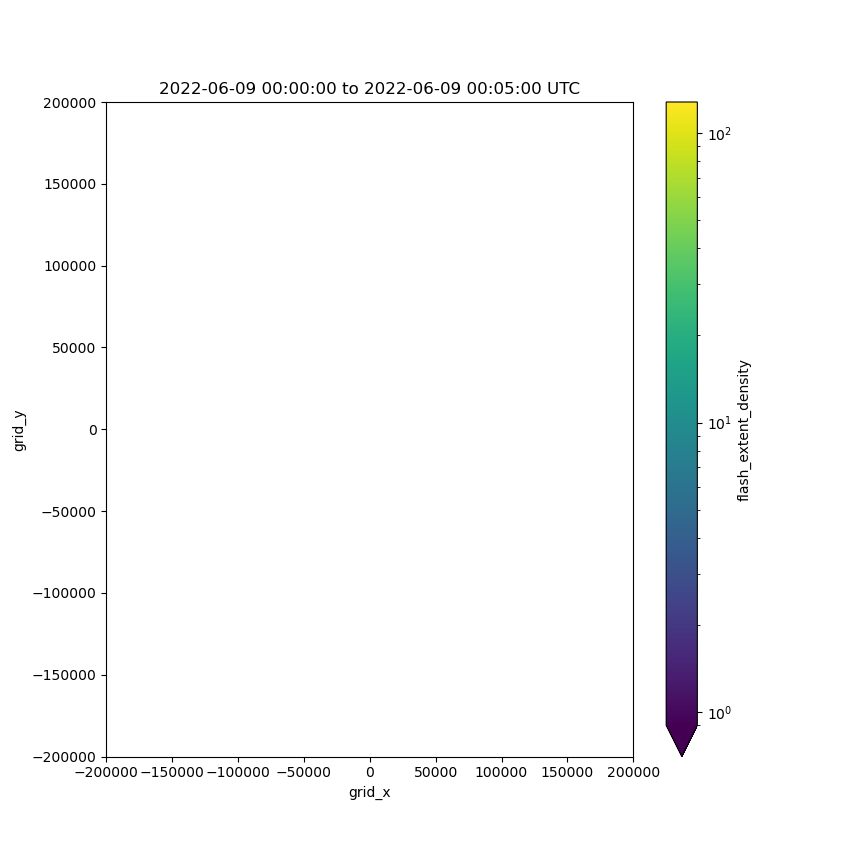

In [31]:
fig = plt.figure(figsize=(8.5, 8.5))
do = interact(plot, fig=fixed(fig), save=fixed(None), var=fixed('flash_extent_density'), norm=fixed(fed_norm),
              time_idx=(0, n_times-1))

**Save the gridded figures above in a loop.**

Change the path.

Next cell makes an .mp4; change the path to ffmpeg to match yours.

In [33]:
# fig = plt.figure(figsize=(8.5, 8.5))
# for ti in range(0, n_times-1):
#     plot(time_idx=ti, fig=fig, var='flash_extent_density', norm=fed_norm, save='./figures/loop_FED/')

In [ ]:
# %%bash
# /Applications/ffmpeg -r 12 -s 850x850 -f image2 -pattern_type glob -i './figures/loop_FED/*.png' -vcodec libx264 -crf 12 -vf scale=850:-1 -pix_fmt yuv420p ./figures/fedloop.mp4

interactive(children=(IntSlider(value=0, description='time_idx', max=287), Output()), _dom_classes=('widget-in…

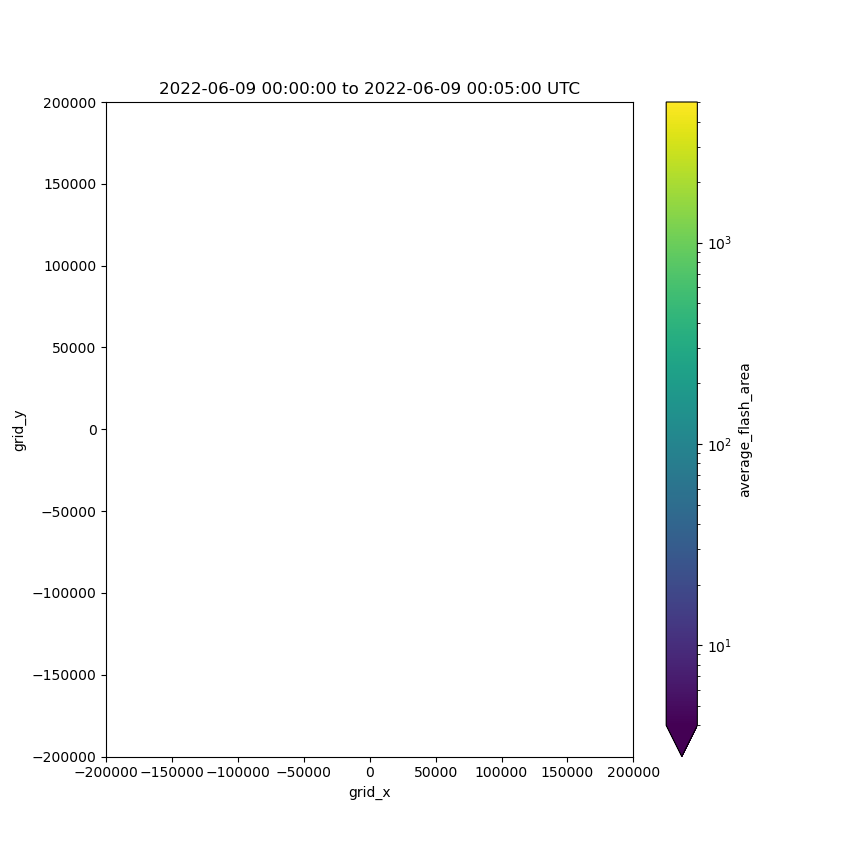

In [34]:
fig = plt.figure(figsize=(8.5, 8.5))
do = interact(plot, fig=fixed(fig), save=fixed(None), var=fixed('average_flash_area'), norm=fixed(afa_norm),
              time_idx=(0, n_times-1))

**Save the figures in a loop.**

Change the path.

Next cell makes an .mp4; change the path to ffmpeg to match yours.

In [ ]:
fig = plt.figure(figsize=(8.5, 8.5))
for ti in range(0, n_times-1):
    plot(time_idx=ti, fig=fig, var='average_flash_area', norm=afa_norm, save='./figures/loop_FED/')

In [ ]:
%%bash
/Applications/ffmpeg -r 12 -s 850x850 -f image2 -pattern_type glob -i './figures/loop_AFA/*.png' -vcodec libx264 -crf 12 -vf scale=850:-1 -pix_fmt yuv420p ./figures/afaloop.mp4